<a href="https://colab.research.google.com/github/tnusser/ImageRetrieval/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [235]:
import tensorflow as tf
import numpy as np
import sklearn
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Conv2DTranspose, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap
import pandas as pd
import sklearn.metrics.pairwise

## 3.1 Dataset Preparation

In [236]:
 (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = tf.keras.datasets.cifar10.load_data()

In [237]:
x_train = (raw_x_train/255).astype("float32")
x_test = (raw_x_test/255).astype("float32")

## 3.2 Building the Autoencoder

In [238]:
x_val = x_train[:4000]
x_train = x_train[4000:]

In [239]:
i = Input(shape=(32, 32, 3), name="input_layer")
e1 = Conv2D(32, (3, 3), padding='same', name="conv_1")(i)
e2 = LeakyReLU(alpha=0.1)(e1)
e3 = Conv2D(64, (3, 3), padding='same', strides=(1,1))(e3)
e2 = LeakyReLU(alpha=0.1)(e1)
e6 = Flatten()(e2)
e7 = Dense(10, name="latent_space")(e6)
e8 = LeakyReLU(alpha=0.1)(e7)

conv_shape = K.int_shape(e1)
d_i = Input(shape=(10,))
d1 = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3],)(d_i)
d3 = LeakyReLU(alpha=0.1)(d1)
d2 = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(d3)
d6 = Conv2DTranspose(filters=3, kernel_size=3, activation="sigmoid", padding="same")(d2)

encoder = Model(i, e8, name='encoder')
encoder.summary()
decoder = Model(d_i, d6, name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 32768)             0         
_________________________________________________________________
latent_space (Dense)         (None, 10)                327690    
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 10)                0         
Total params: 328,586
Trainable params: 328,586
Non-trainable params: 0
_____________________________________________________

In [240]:
autoencoder_outputs = decoder(encoder(i))
autoencoder = Model(i, autoencoder_outputs, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                328586    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         361315    
Total params: 689,901
Trainable params: 689,901
Non-trainable params: 0
_________________________________________________________________


In [241]:
checkpoint = ModelCheckpoint('best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=50, batch_size=512, callbacks=[checkpoint, earlystopping])

Train on 46000 samples, validate on 4000 samples
Epoch 1/50
46000/46000 [==============================] - 63s 1ms/step - loss: 0.0406 - accuracy: 0.4941 - val_loss: 0.0280 - val_accuracy: 0.5716

Epoch 00001: val_accuracy improved from -inf to 0.57159, saving model to best.hdf5
Epoch 2/50
46000/46000 [==============================] - 65s 1ms/step - loss: 0.0243 - accuracy: 0.5868 - val_loss: 0.0231 - val_accuracy: 0.5952

Epoch 00002: val_accuracy improved from 0.57159 to 0.59524, saving model to best.hdf5
Epoch 3/50
46000/46000 [==============================] - 63s 1ms/step - loss: 0.0225 - accuracy: 0.5990 - val_loss: 0.0232 - val_accuracy: 0.5923

Epoch 00003: val_accuracy did not improve from 0.59524
Epoch 4/50
46000/46000 [==============================] - 63s 1ms/step - loss: 0.0224 - accuracy: 0.6014 - val_loss: 0.0225 - val_accuracy: 0.6082

Epoch 00004: val_accuracy improved from 0.59524 to 0.60824, saving model to best.hdf5
Epoch 5/50
46000/46000 [=========================

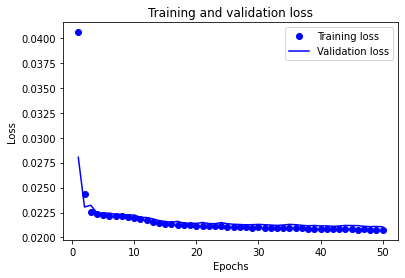

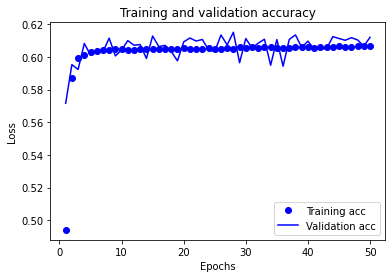

In [242]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [244]:
autoencoder.load_weights("best.hdf5")
preds = autoencoder.predict(x_test)

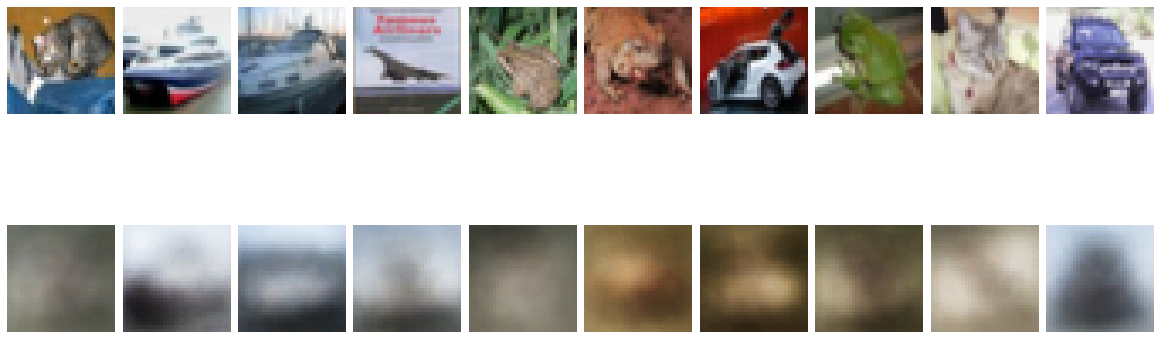

In [245]:
f, axarr = plt.subplots(2, 10, constrained_layout=True)
f.set_size_inches(16, 6)
for i in range(10):
    original = x_test[i]
    axarr[0, i].imshow(original)
    axarr[0, i].axis('off')
    prediction = preds[i]
    axarr[1, i].imshow(prediction)
    axarr[1, i].axis('off')
plt.show()


In [246]:
samples = random.sample(list(x_test), 50)
intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").get_layer("latent_space").output)

intermediate_output = intermediate_layer_model.predict(np.asarray(samples))

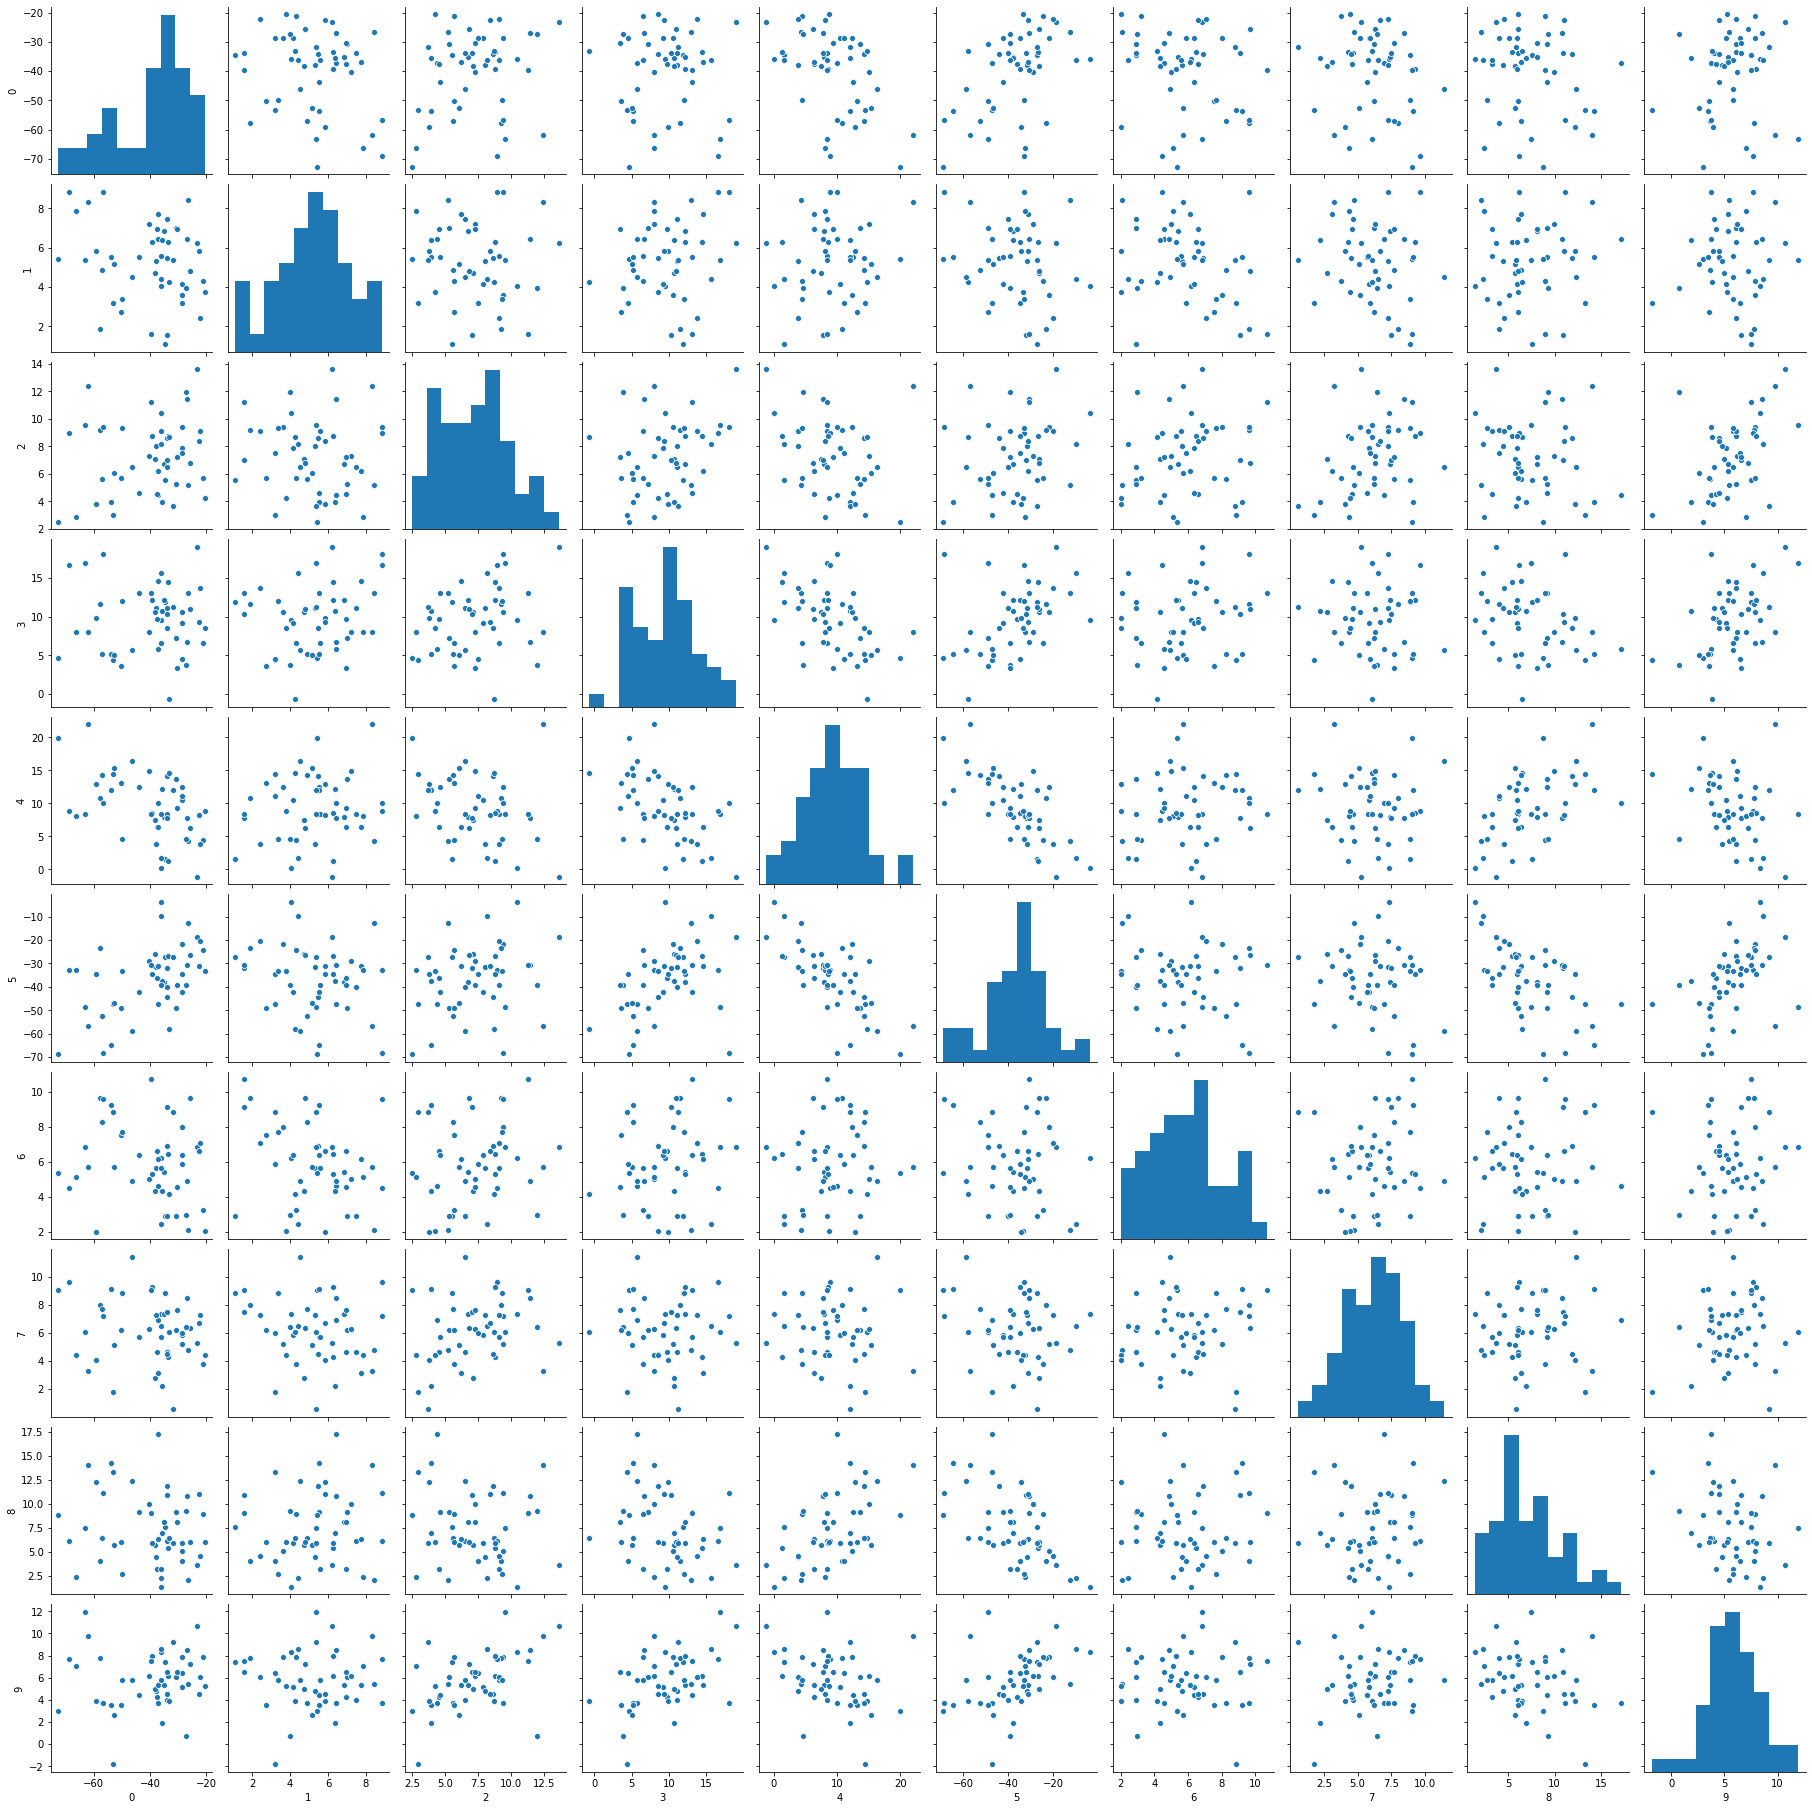

In [247]:
df = pd.DataFrame(intermediate_output)
sns.pairplot(df)

In [248]:
latentspace_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").get_layer("latent_space").output)
latentspace = latentspace_layer_model.predict(x_test)


In [256]:
trans = umap.UMAP().fit(latentspace)

In [250]:
print(raw_y_test)
y_test = np.concatenate(raw_y_test).ravel()
print(y_test)

[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
[3 8 8 ... 5 1 7]


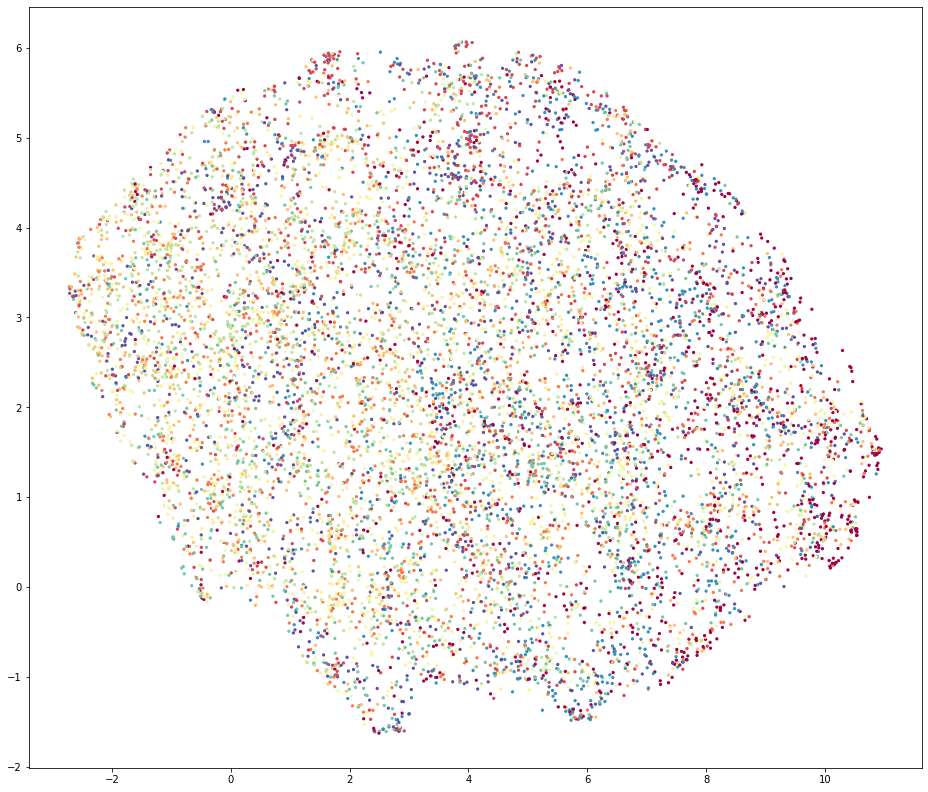

In [257]:
plt.figure(figsize=(16, 14))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_test, cmap='Spectral')

In [252]:
query_image_tuple= random.sample(list(enumerate(x_test)), 20)
query_images = []
for query_image in query_image_tuple:
  query_images.append(query_image[1])

In [253]:
query_images_latentspace = latentspace_layer_model.predict(np.asarray(query_images))
data = np.concatenate((x_train, x_test), axis = 0)
all_latentspaces = latentspace_layer_model.predict(data)

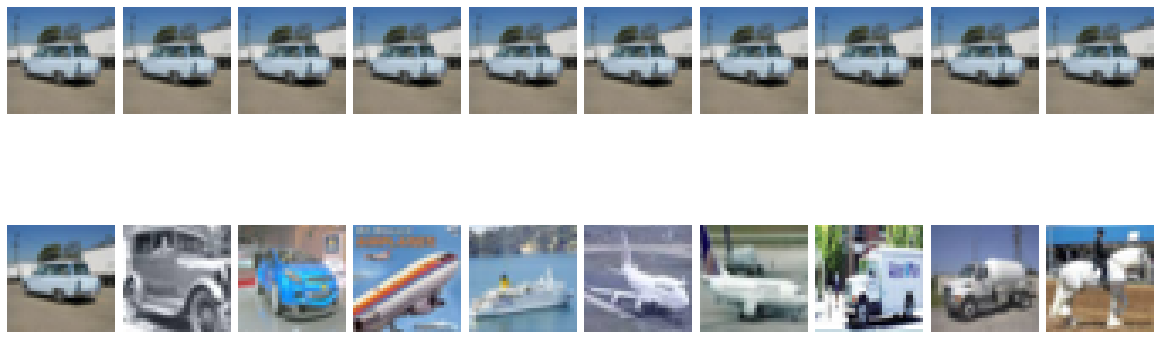

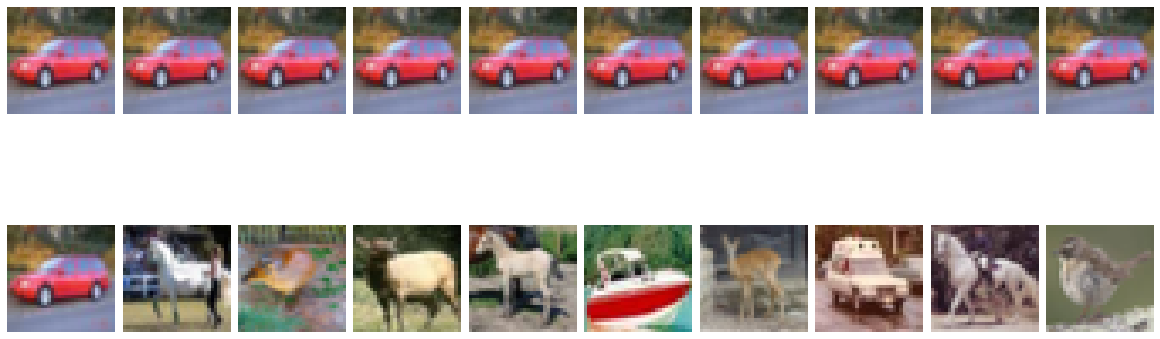

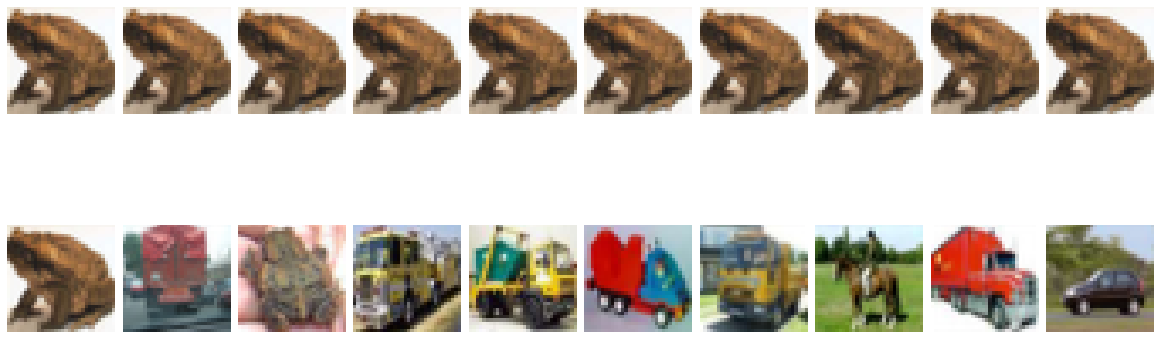

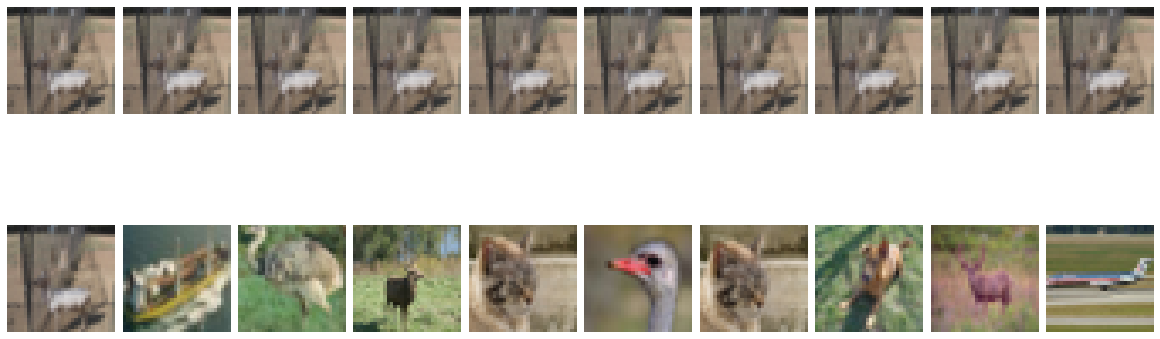

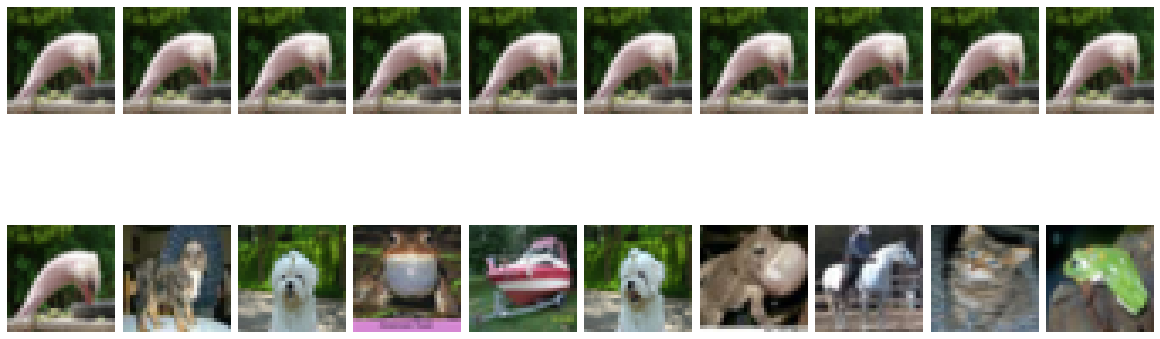

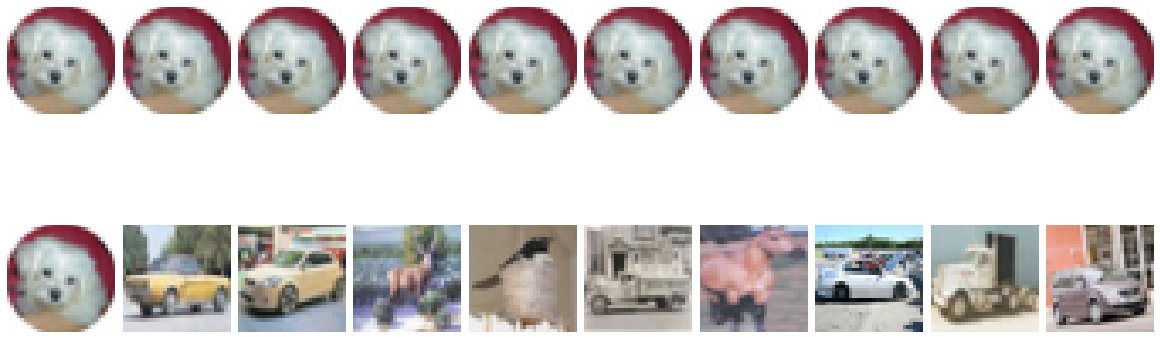

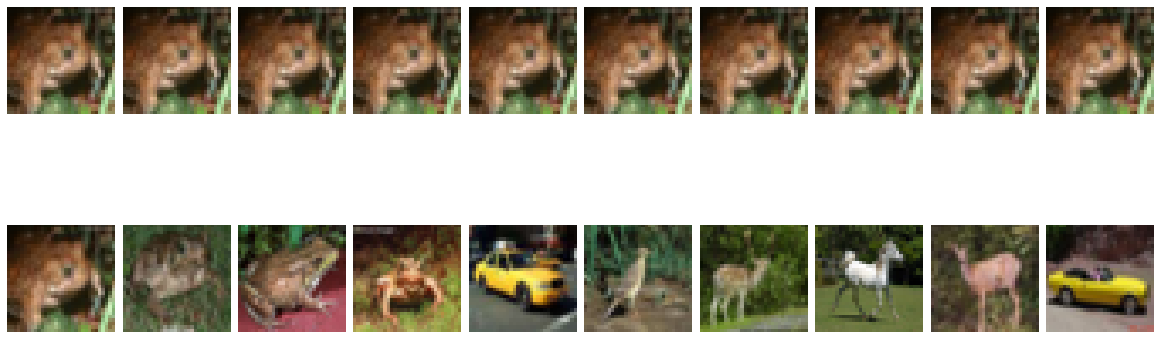

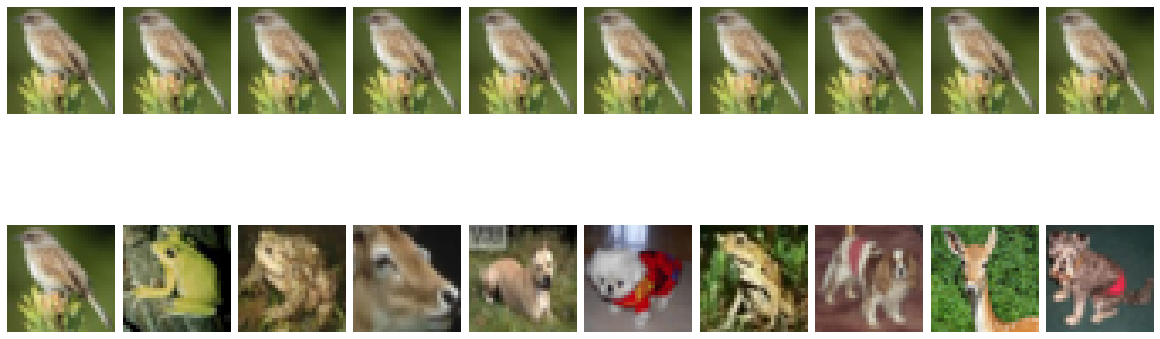

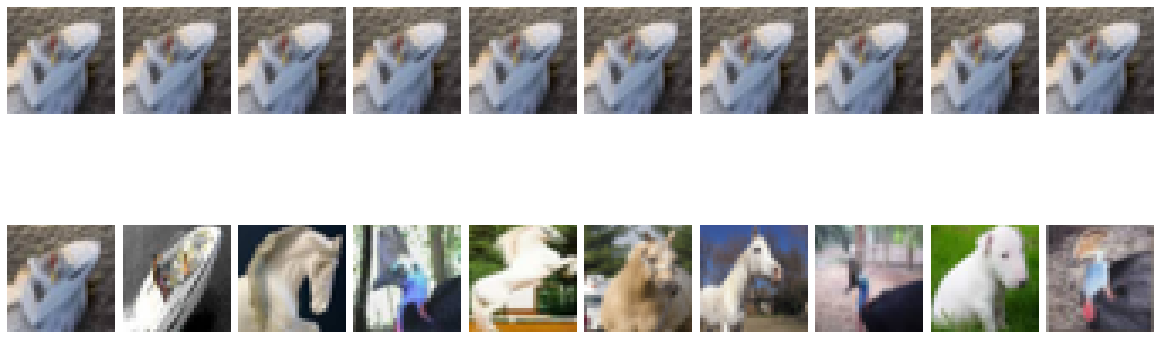

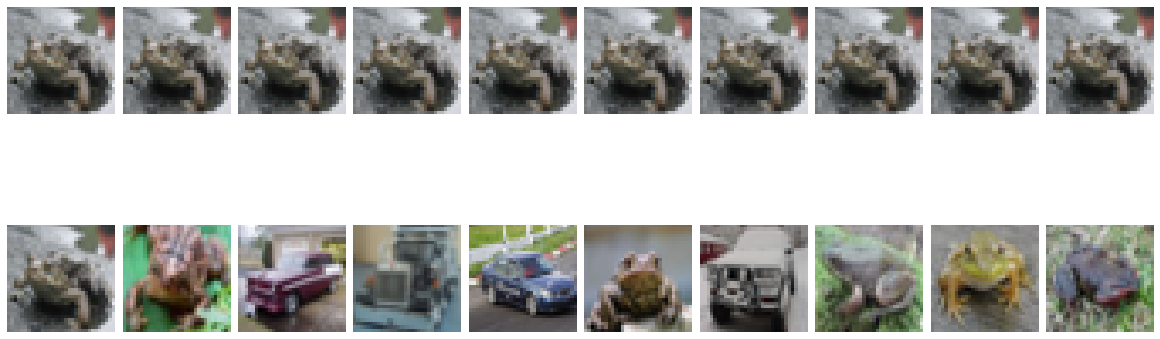

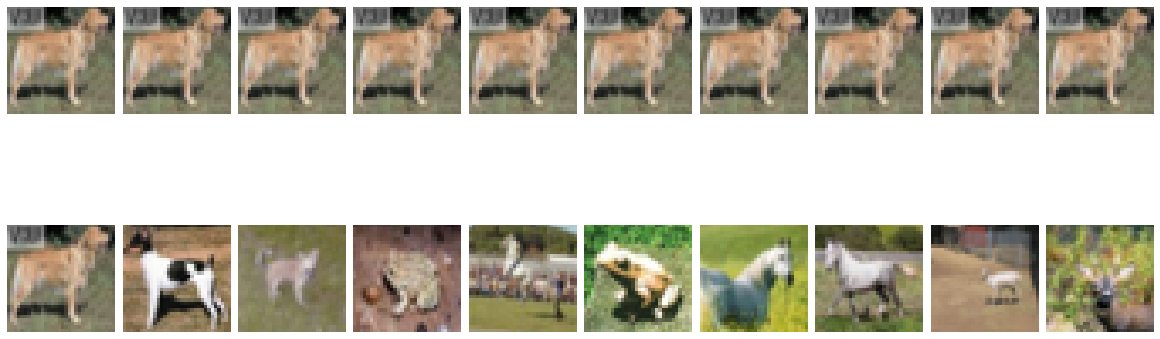

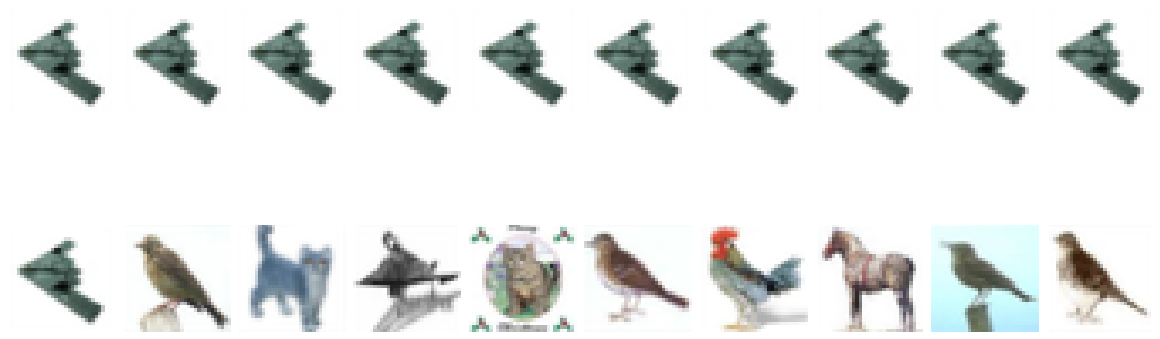

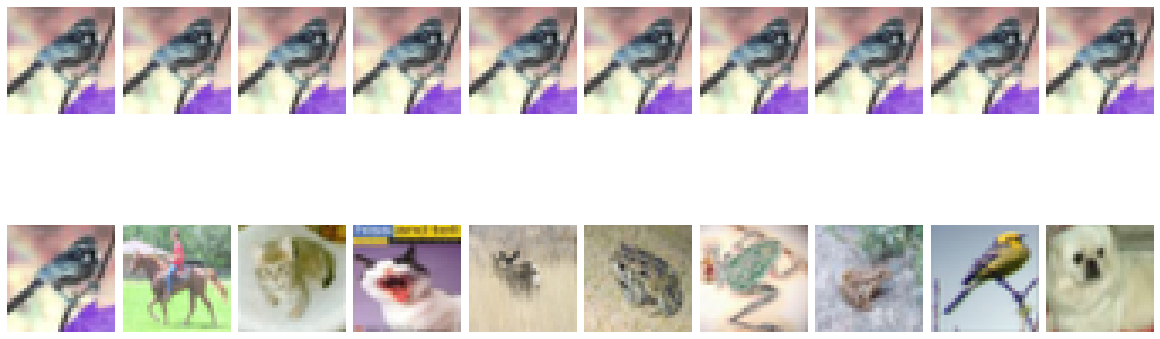

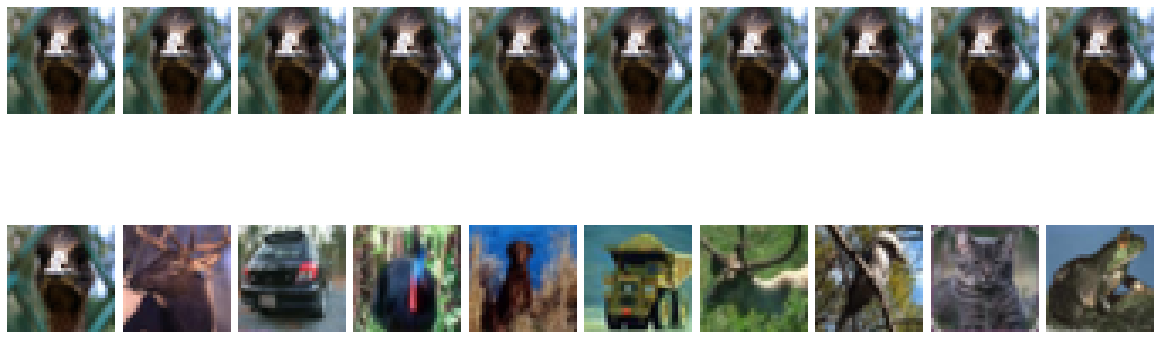

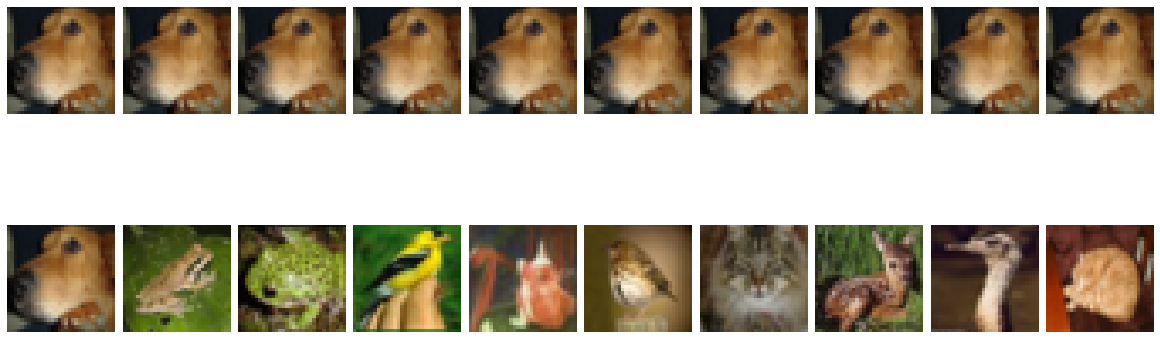

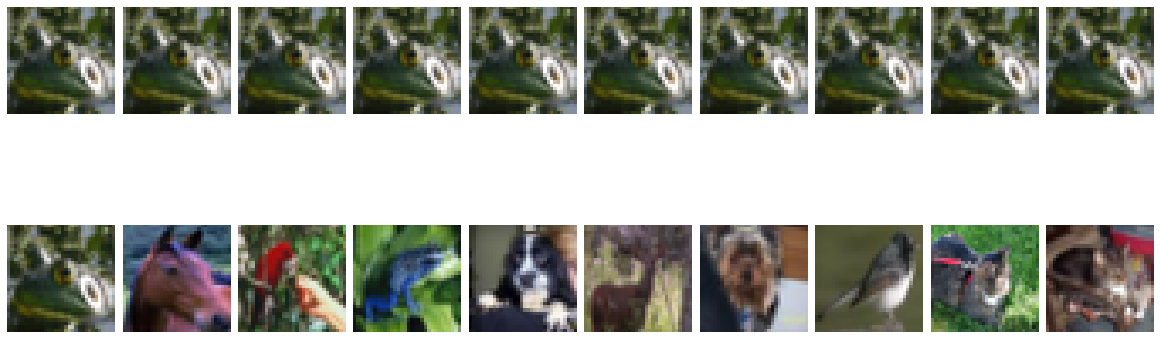

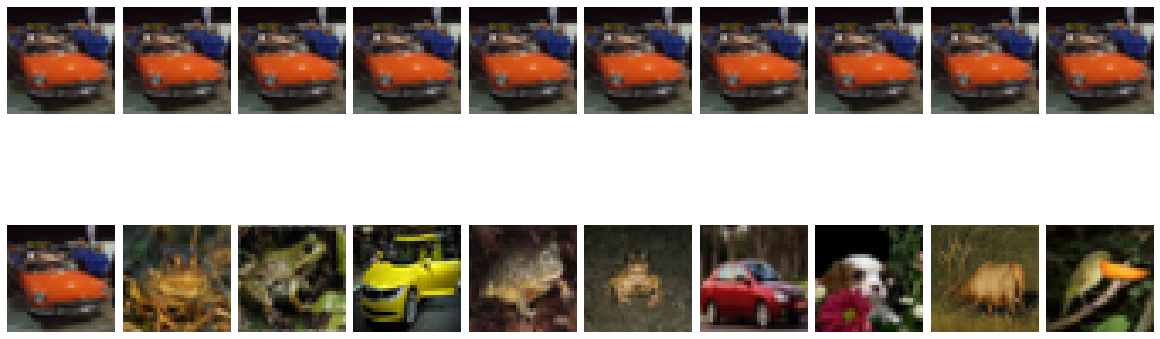

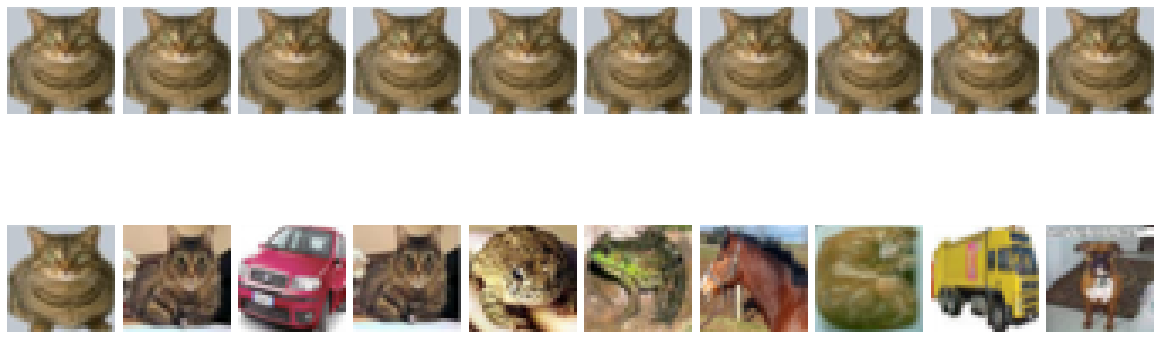

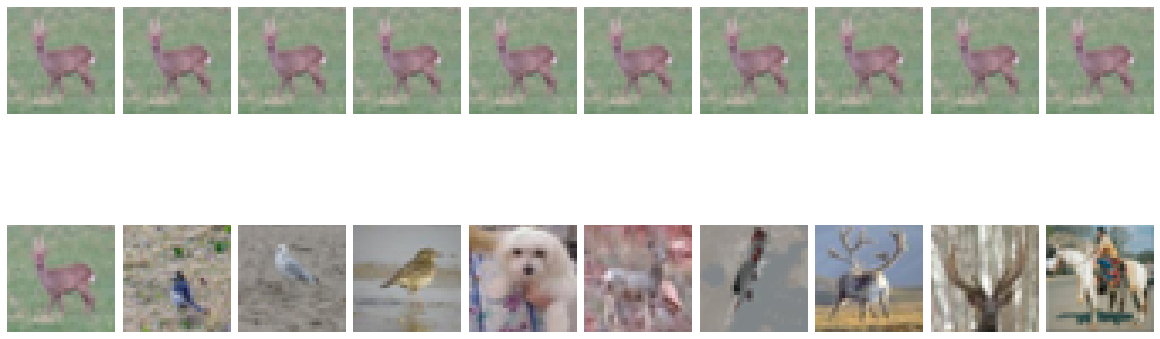

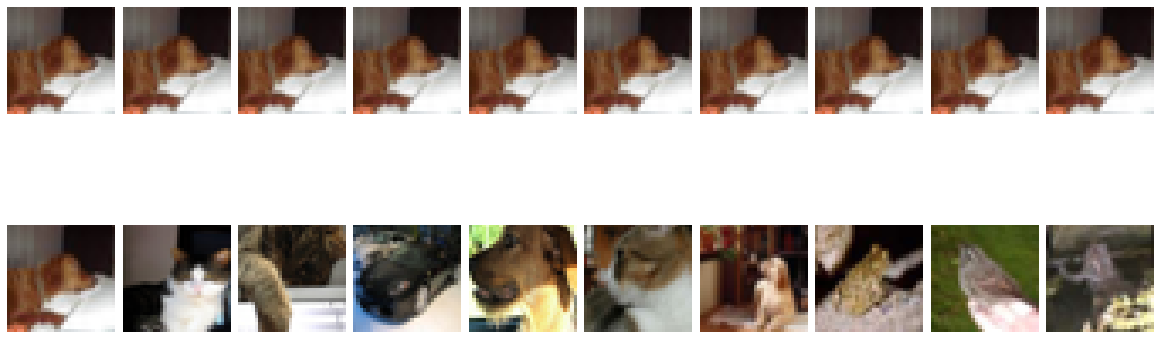

In [255]:
for j, q_image in enumerate(query_images_latentspace):
  dist_dict = {}
  for i, img in enumerate(all_latentspaces):
    dist_dict[i] = sklearn.metrics.pairwise_distances((q_image, img), metric="cosine")[0][1]
  top10 = sorted(dist_dict.items(), key=lambda x: x[1])[:10]
  f, axarr = plt.subplots(2, 10, constrained_layout=True)
  f.set_size_inches(16, 6)
  for i, k in enumerate(top10):
      axarr[0, i].imshow(x_test[query_image_tuple[j][0]])
      axarr[0, i].axis('off')
      prediction = data[k[0]]
      axarr[1, i].imshow(prediction)
      axarr[1, i].axis('off')
  plt.show()
